In [ ]:
import pandas as pd


# --- 1. Preparação dos Dados ---
df = pd.read_csv(r"C:\Users\josef\Documents\UnB\prev_sharc\dados_atualizados_expandido.csv")


In [9]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import joblib

# --- Parâmetros da cGAN ---
latent_dim = 32
conditional_dim = 2
data_dim = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, data_dim),
            nn.Tanh()
        )

    def forward(self, noise, conditions):
        merged_input = torch.cat((noise, conditions), -1)
        return self.model(merged_input)

base_path = os.path.join(os.getcwd(), "modelo_5000_drops")

generator = Generator().to(device)
model_path = os.path.join(base_path, "generator_modelo_5500.pth")
generator.load_state_dict(torch.load(model_path, map_location=device))
generator.eval()

# Carregar scalers
scaler_cond_path = os.path.join(base_path, "condition_scaler_modelo_5500.joblib")
scaler_output_path = os.path.join(base_path, "data_scaler_modelo_5500.joblib")
scaler_cond = joblib.load(scaler_cond_path)
scaler_output = joblib.load(scaler_output_path)

def prever_path_loss(df):
    # Normalizar condições
    cond_scaled = scaler_cond.transform(df[['bs_x', 'bs_y']])
    conditions_tensor = torch.tensor(cond_scaled, dtype=torch.float32).to(device)

    # Gerar ruído aleatório
    noise = torch.randn(len(df), latent_dim).to(device)

    # Gerar previsão
    with torch.no_grad():
        fake_path_loss_scaled = generator(noise, conditions_tensor).cpu().numpy()

    # Desnormalizar saída
    fake_path_loss_real = scaler_output.inverse_transform(fake_path_loss_scaled)

    return fake_path_loss_real

# Exemplo
df_teste = pd.DataFrame({
    'bs_x': [100.5, 101.2],
    'bs_y': [200.7, 202.1]
})

predicoes = prever_path_loss(df_teste)
print(predicoes)


Usando dispositivo: cpu


C:\Users\josef\AppData\Local\Temp\ipykernel_14024\1306448234.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_locati

[[194.80069]
 [194.37006]]


c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [12]:
def prever_path_loss_batch(df, batch_size=10000):
    resultados = []

    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        df_batch = df.iloc[start:end]

        cond_scaled = scaler_cond.transform(df_batch[['bs_x', 'bs_y']])
        conditions_tensor = torch.tensor(cond_scaled, dtype=torch.float32).to(device)

        noise = torch.randn(len(df_batch), latent_dim).to(device)

        with torch.no_grad():
            fake_path_loss_scaled = generator(noise, conditions_tensor).cpu().numpy()

        fake_path_loss_real = scaler_output.inverse_transform(fake_path_loss_scaled)
        resultados.append(fake_path_loss_real)

    return np.vstack(resultados)


In [13]:
predicoes = prever_path_loss_batch(df)
df['path_loss_predito'] = predicoes
print(df.head())


c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\josef\AppData\Local\r

   bs_x        bs_y        ue_x        ue_y  ue_bs_distance   path_loss  \
0   300  519.615242  228.146697  564.084077       86.096600  184.631851   
1   300  519.615242   18.857989  437.357635      293.392901  184.631851   
2   300  519.615242    0.117657  639.348238      323.322842  184.631851   
3  -300  519.615242 -202.975152  212.620784      322.384349  194.039715   
4  -300  519.615242  -64.734778  432.429233      251.442588  194.039715   

   path_loss_predito  
0         184.662857  
1         190.450409  
2         190.759338  
3         188.164398  
4         195.462769  


c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


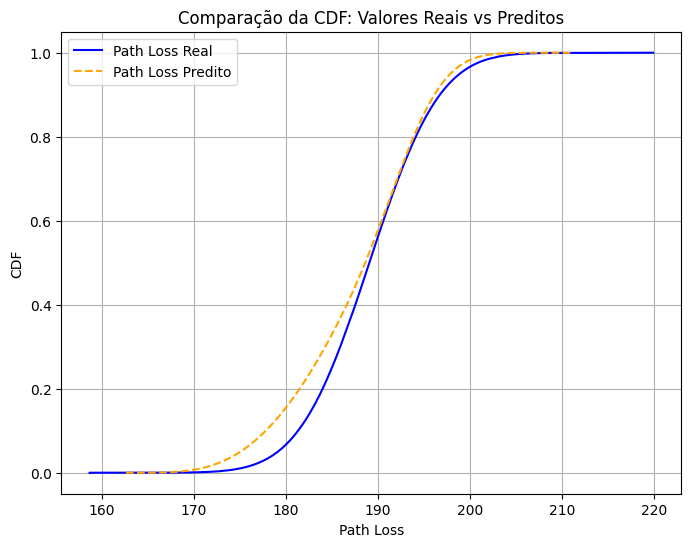

In [14]:
import numpy as np

def cdf(data):
    data_sorted = np.sort(data)
    n = len(data_sorted)
    y = np.arange(1, n+1) / n
    return data_sorted, y

import matplotlib.pyplot as plt

# Extrair os dados
real = df['path_loss'].values
predito = df['path_loss_predito'].values.flatten()  # garante formato 1D

# Calcular CDFs
x_real, y_real = cdf(real)
x_predito, y_predito = cdf(predito)

# Plot
plt.figure(figsize=(8,6))
plt.plot(x_real, y_real, label='Path Loss Real', color='blue')
plt.plot(x_predito, y_predito, label='Path Loss Predito', color='orange', linestyle='--')
plt.xlabel('Path Loss')
plt.ylabel('CDF')
plt.title('Comparação da CDF: Valores Reais vs Preditos')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(f"Tamanho do df_filtrado: {len(df_filtrado)}")
print("Valores únicos de path_loss real:", np.unique(df_filtrado['path_loss'].values))
print("Valores únicos de path_loss predito:", np.unique(df_filtrado['path_loss_predito'].values))

print("Exemplo de path_loss real:", df_filtrado['path_loss'].head())
print("Exemplo de path_loss predito:", df_filtrado['path_loss_predito'].head())


Tamanho do df_filtrado: 86670
Valores únicos de path_loss real: [165.93623896 166.18905832 167.74449385 ... 211.03768238 211.81472245
 217.60749636]
Valores únicos de path_loss predito: [164.355   164.8738  164.9445  ... 205.28122 205.33354 205.76181]
Exemplo de path_loss real: 0      184.631851
1      184.631851
2      184.631851
249    191.815834
250    191.815834
Name: path_loss, dtype: float64
Exemplo de path_loss predito: 0      184.662857
1      190.450409
2      190.759338
249    198.253693
250    185.833313
Name: path_loss_predito, dtype: float32


In [18]:
tolerancia = 1e-5
df_filtrado = df[
    (df['bs_x'] == 300) &
    (np.abs(df['bs_y'] - 519.615242) < tolerancia)
]


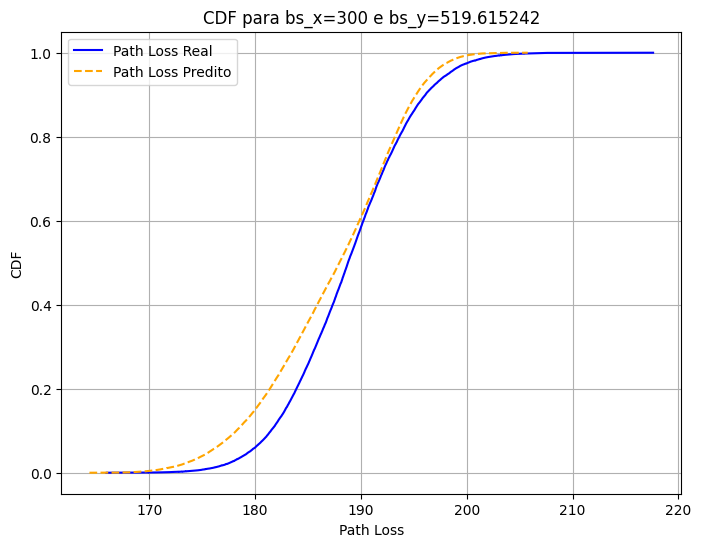

In [20]:
# Função para calcular a CDF
def cdf(data):
    data_sorted = np.sort(data)
    n = len(data_sorted)
    y = np.arange(1, n+1) / n
    return data_sorted, y

# Extrair reais e preditos
real = df_filtrado['path_loss'].values
predito = df_filtrado['path_loss_predito'].values.flatten()

# Calcular CDFs
x_real, y_real = cdf(real)
x_predito, y_predito = cdf(predito)

# Plot
plt.figure(figsize=(8,6))
plt.plot(x_real, y_real, label='Path Loss Real', color='blue')
plt.plot(x_predito, y_predito, label='Path Loss Predito', color='orange', linestyle='--')
plt.xlabel('Path Loss')
plt.ylabel('CDF')
plt.title('CDF para bs_x=300 e bs_y=519.615242')
plt.legend()
plt.grid(True)
plt.show()

Pares selecionados:
   bs_x         bs_y
0     0 -3117.691454
1     0  1039.230485
2 -1200  1039.230485
3 -2400 -2078.460969
4  2400 -2078.460969
5  -600  3117.691454


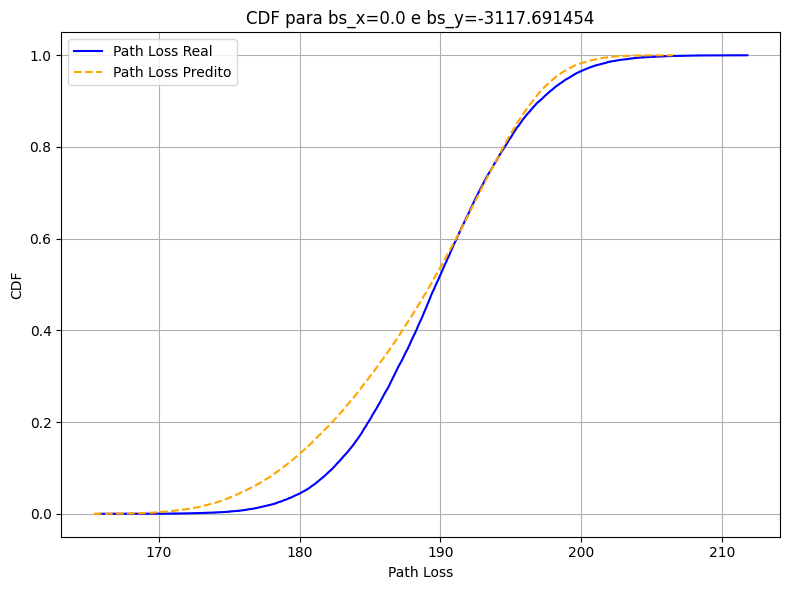

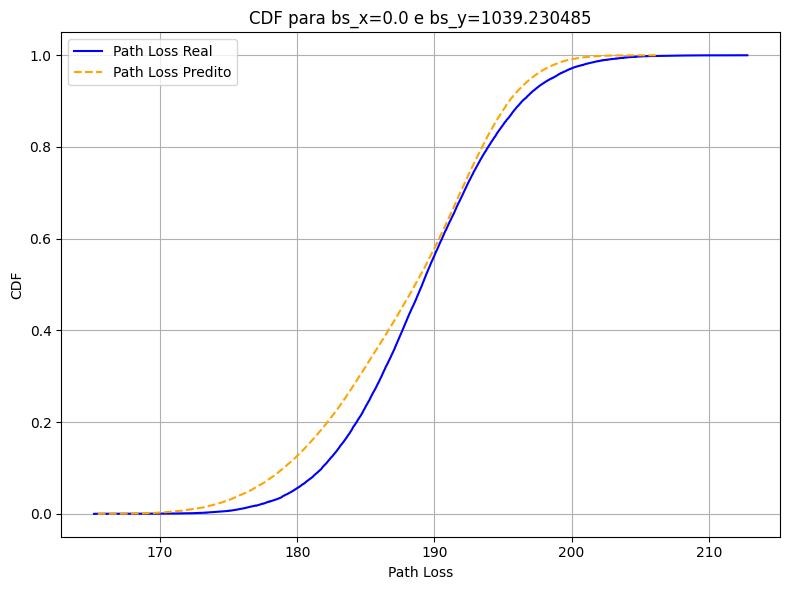

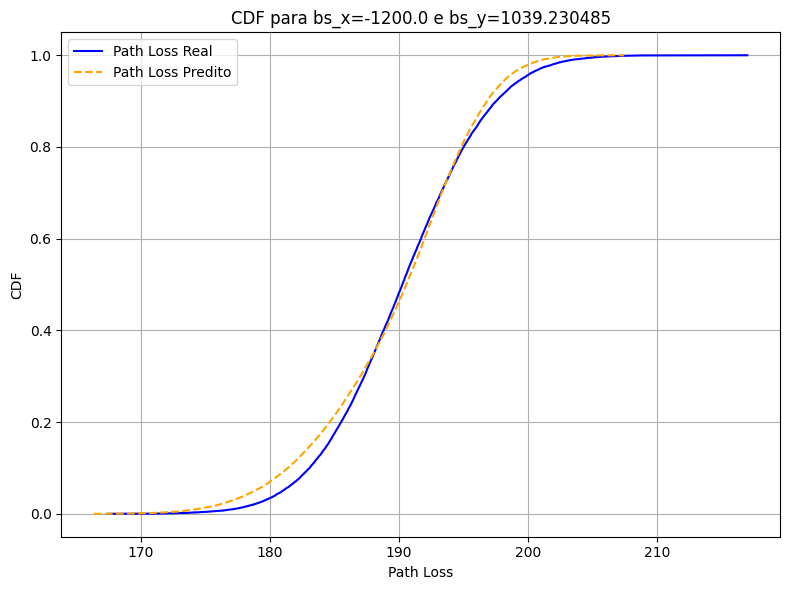

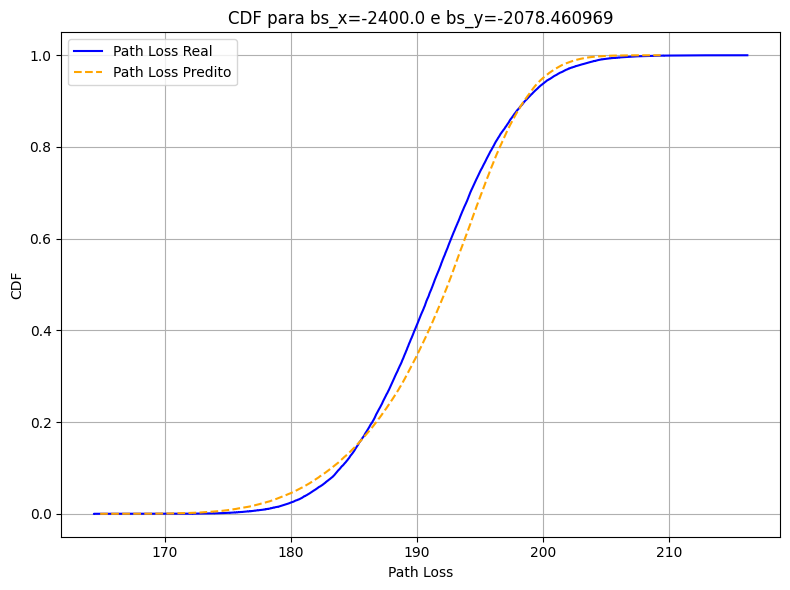

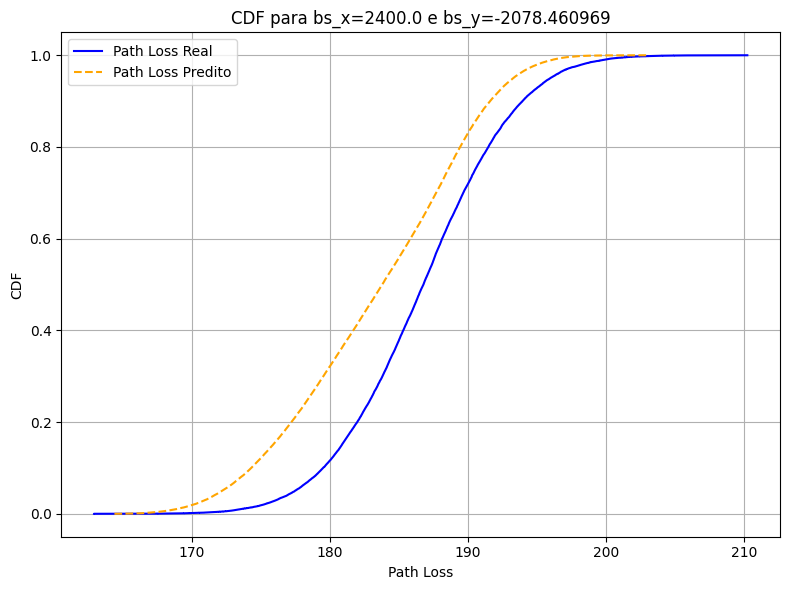

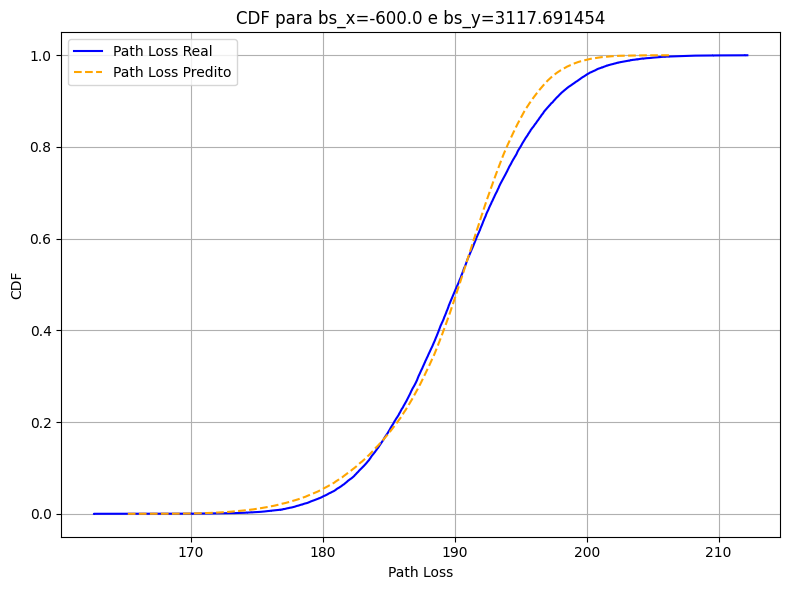

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Selecionar 6 pares únicos aleatórios de (bs_x, bs_y)
pares_unicos = df[['bs_x', 'bs_y']].drop_duplicates()
num_pares = min(6, len(pares_unicos))
pares_selecionados = pares_unicos.sample(num_pares, random_state=42).reset_index(drop=True)

print("Pares selecionados:")
print(pares_selecionados)

def cdf(data):
    data_sorted = np.sort(data)
    n = len(data_sorted)
    y = np.arange(1, n+1) / n
    return data_sorted, y

# Loop para gerar gráficos separados
for idx, (bsx, bsy) in pares_selecionados.iterrows():
    tolerancia = 1e-5
    df_filtrado = df[
        (df['bs_x'] == bsx) &
        (np.abs(df['bs_y'] - bsy) < tolerancia)
    ]
    
    if len(df_filtrado) == 0:
        print(f"Nenhum dado para bs_x={bsx}, bs_y={bsy}")
        continue
    
    real = df_filtrado['path_loss'].values
    predito = df_filtrado['path_loss_predito'].values.flatten()
    
    x_real, y_real = cdf(real)
    x_predito, y_predito = cdf(predito)
    
    plt.figure(figsize=(8,6))
    plt.plot(x_real, y_real, label='Path Loss Real', color='blue')
    plt.plot(x_predito, y_predito, label='Path Loss Predito', color='orange', linestyle='--')
    plt.xlabel('Path Loss')
    plt.ylabel('CDF')
    plt.title(f'CDF para bs_x={bsx} e bs_y={bsy:.6f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


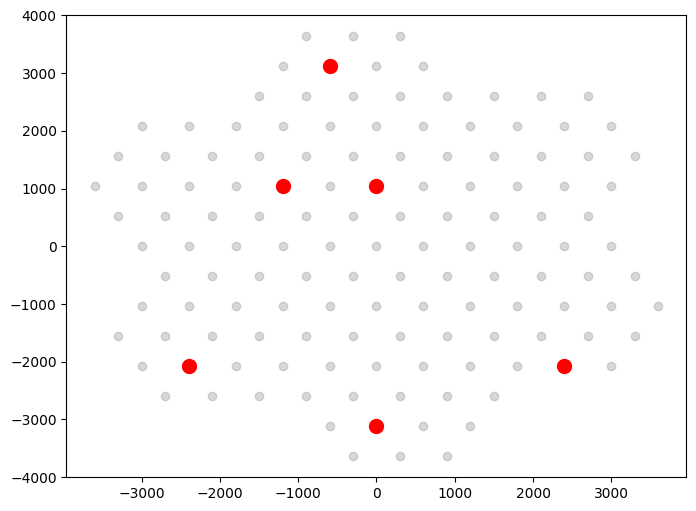

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(pares_unicos['bs_x'], pares_unicos['bs_y'], alpha=0.3, label='Todos os pares', color='gray')
plt.scatter(pares_selecionados['bs_x'], pares_selecionados['bs_y'], color='red', label='Pares selecionados', s=100)
